In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [2]:
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
#pull the data
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [4]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


#### Data Cleaning

In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [6]:
housing_df.isnull().mean()

id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
street           0.000000
alley            0.937671
lotshape         0.000000
landcontour      0.000000
utilities        0.000000
lotconfig        0.000000
landslope        0.000000
neighborhood     0.000000
condition1       0.000000
condition2       0.000000
bldgtype         0.000000
housestyle       0.000000
overallqual      0.000000
overallcond      0.000000
yearbuilt        0.000000
yearremodadd     0.000000
roofstyle        0.000000
roofmatl         0.000000
exterior1st      0.000000
exterior2nd      0.000000
masvnrtype       0.005479
masvnrarea       0.005479
exterqual        0.000000
extercond        0.000000
foundation       0.000000
                   ...   
bedroomabvgr     0.000000
kitchenabvgr     0.000000
kitchenqual      0.000000
totrmsabvgrd     0.000000
functional       0.000000
fireplaces       0.000000
fireplacequ      0.472603
garagetype  

Right off the bat, there seems to be a few obvious ways to trim this data set. Some columns are highly specific subsets of other categories which can be easily discarded. Another is things like alley type missing more than 90% of values, which surely represents no alley access, so we can turn that column into a boolean -- true or false if there is any alley access. Lastly we can drop ambiguous columns like 'misc. features'.

In [7]:
##check non-null alley values
housing_df['alley'].loc[housing_df['alley'].isnull()==False].head()

21    Grvl
30    Pave
56    Pave
79    Grvl
87    Pave
Name: alley, dtype: object

In [8]:
housing_df['alley'].head()

0    None
1    None
2    None
3    None
4    None
Name: alley, dtype: object

In [9]:
##Fill null values with false
housing_df['alley'].fillna(value=False, inplace=True)

In [10]:
housing_df['alley'].head()

0    False
1    False
2    False
3    False
4    False
Name: alley, dtype: object

In [11]:
##turn alley column to true or false
housing_df.loc[housing_df['alley'] != False, 'alley'] = True

Instead of whittling down to the important categories, I think it's smarter to build from the ground up and add obviously important columns first to the features for our model.

In [12]:
##create new df with more focused features to explore
model_features = (housing_df[['saleprice','yrsold','mosold','yearbuilt','yearremodadd','lotarea','neighborhood','alley','overallqual','overallcond',
                              'bldgtype','housestyle','totalbsmtsf','grlivarea','fullbath','bedroomabvgr','kitchenqual','functional','garagecars',
                             'paveddrive','wooddecksf','poolarea']]).copy()

In [13]:
#show percent null values for each column
model_features.isnull().mean()

saleprice       0.0
yrsold          0.0
mosold          0.0
yearbuilt       0.0
yearremodadd    0.0
lotarea         0.0
neighborhood    0.0
alley           0.0
overallqual     0.0
overallcond     0.0
bldgtype        0.0
housestyle      0.0
totalbsmtsf     0.0
grlivarea       0.0
fullbath        0.0
bedroomabvgr    0.0
kitchenqual     0.0
functional      0.0
garagecars      0.0
paveddrive      0.0
wooddecksf      0.0
poolarea        0.0
dtype: float64

Now we have a more focused dataset without any null values. Time to explore the data.

#### Data Exploration

We'll focus on saleprice as our target variable.

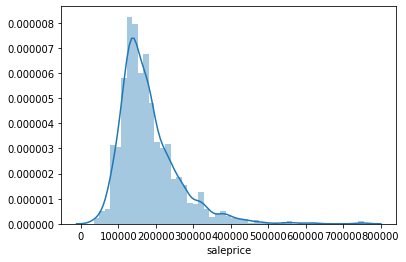

In [14]:
#plot saleprice distribution
sns.distplot(model_features.saleprice)

Our target variable seems to be non-normal and skewed to the right. It's time to turn our categorical variables into binary ones in order to research their correlations to our target.

In [15]:
model_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
saleprice       1460 non-null int64
yrsold          1460 non-null int64
mosold          1460 non-null int64
yearbuilt       1460 non-null int64
yearremodadd    1460 non-null int64
lotarea         1460 non-null int64
neighborhood    1460 non-null object
alley           1460 non-null bool
overallqual     1460 non-null int64
overallcond     1460 non-null int64
bldgtype        1460 non-null object
housestyle      1460 non-null object
totalbsmtsf     1460 non-null int64
grlivarea       1460 non-null int64
fullbath        1460 non-null int64
bedroomabvgr    1460 non-null int64
kitchenqual     1460 non-null object
functional      1460 non-null object
garagecars      1460 non-null int64
paveddrive      1460 non-null object
wooddecksf      1460 non-null int64
poolarea        1460 non-null int64
dtypes: bool(1), int64(15), object(6)
memory usage: 206.8+ KB


In [16]:
##number of unique values in neighborhood
model_features.neighborhood.nunique()

25

While neighborhood seems to be an important piece of information, 25 seperate categories is too many for our model.

In [17]:
# drop neighborhood
model_features.drop(columns=['neighborhood'], inplace=True)

In [18]:
model_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
saleprice       1460 non-null int64
yrsold          1460 non-null int64
mosold          1460 non-null int64
yearbuilt       1460 non-null int64
yearremodadd    1460 non-null int64
lotarea         1460 non-null int64
alley           1460 non-null bool
overallqual     1460 non-null int64
overallcond     1460 non-null int64
bldgtype        1460 non-null object
housestyle      1460 non-null object
totalbsmtsf     1460 non-null int64
grlivarea       1460 non-null int64
fullbath        1460 non-null int64
bedroomabvgr    1460 non-null int64
kitchenqual     1460 non-null object
functional      1460 non-null object
garagecars      1460 non-null int64
paveddrive      1460 non-null object
wooddecksf      1460 non-null int64
poolarea        1460 non-null int64
dtypes: bool(1), int64(15), object(5)
memory usage: 201.1+ KB


In [19]:
model_features.bldgtype.nunique()

5

In [20]:
model_features.housestyle.nunique()

8

In [21]:
model_features.kitchenqual.nunique()

4

In [22]:
model_features.paveddrive.nunique()

3

For our purposes here, I'll drop the categorical variables and work with the numeric.

In [23]:
##drop categorical columns
model_features.drop(columns=['bldgtype','housestyle','kitchenqual','functional','paveddrive'], inplace=True)

In [24]:
model_features.head()

,saleprice,yrsold,mosold,yearbuilt,yearremodadd,lotarea,alley,overallqual,overallcond,totalbsmtsf,grlivarea,fullbath,bedroomabvgr,garagecars,wooddecksf,poolarea
0,208500,2008,2,2003,2003,8450,False,7,5,856,1710,2,3,2,0,0
1,181500,2007,5,1976,1976,9600,False,6,8,1262,1262,2,3,2,298,0
2,223500,2008,9,2001,2002,11250,False,7,5,920,1786,2,3,2,0,0
3,140000,2006,2,1915,1970,9550,False,7,5,756,1717,1,3,3,0,0
4,250000,2008,12,2000,2000,14260,False,8,5,1145,2198,2,4,3,192,0


In [25]:
model_features.corr()

,saleprice,yrsold,mosold,yearbuilt,yearremodadd,lotarea,alley,overallqual,overallcond,totalbsmtsf,grlivarea,fullbath,bedroomabvgr,garagecars,wooddecksf,poolarea
saleprice,1.000000,-0.028923,0.046432,0.522897,0.507101,0.263843,-0.123611,0.790982,-0.077856,0.613581,0.708624,0.560664,0.168213,0.640409,0.324413,0.092404
yrsold,-0.028923,1.000000,-0.145721,-0.013618,0.035743,-0.014261,-0.017571,-0.027347,0.043950,-0.014969,-0.036526,-0.019669,-0.036014,-0.039117,0.022270,-0.059689
mosold,0.046432,-0.145721,1.000000,0.012398,0.021490,0.001205,-0.018130,0.070815,-0.003511,0.013196,0.050240,0.055872,0.046544,0.040522,0.021011,-0.033737
yearbuilt,0.522897,-0.013618,0.012398,1.000000,0.592855,0.014228,-0.253115,0.572323,-0.375983,0.391452,0.199010,0.468271,-0.070651,0.537850,0.224880,0.004950
yearremodadd,0.507101,0.035743,0.021490,0.592855,1.000000,0.013788,-0.034565,0.550684,0.073741,0.291066,0.287389,0.439046,-0.040581,0.420622,0.205726,0.005829
lotarea,0.263843,-0.014261,0.001205,0.014228,0.013788,1.000000,-0.075624,0.105806,-0.005636,0.260833,0.263116,0.126031,0.119690,0.154871,0.171698,0.077672
alley,-0.123611,-0.017571,-0.018130,-0.253115,-0.034565,-0.075624,1.000000,-0.067704,0.072953,-0.134872,-0.012589,-0.038178,0.014432,-0.071330,-0.114649,-0.017710
overallqual,0.790982,-0.027347,0.070815,0.572323,0.550684,0.105806,-0.067704,1.000000,-0.091932,0.537808,0.593007,0.550600,0.101676,0.600671,0.238923,0.065166
overallcond,-0.077856,0.043950,-0.003511,-0.375983,0.073741,-0.005636,0.072953,-0.091932,1.000000,-0.171098,-0.079686,-0.194149,0.012980,-0.185758,-0.003334,-0.001985
totalbsmtsf,0.613581,-0.014969,0.013196,0.391452,0.291066,0.260833,-0.134872,0.537808,-0.171098,1.000000,0.454868,0.323722,0.050450,0.434585,0.232019,0.126053


We can take the 5 most correlated features from here, keeping in mind to avoid correlated independent variables.

### Regression Model

In [26]:
import statsmodels.api as sm

##choose the features for the model
X = model_features[['overallqual','totalbsmtsf','grlivarea','garagecars','fullbath']]
##sale price is target variable
Y = model_features.saleprice

In [27]:
##create linear regression object
lrm = linear_model.LinearRegression()

In [29]:
##get and print coefficients using OLS
lrm.fit(X, Y)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [23468.50871893    32.62410932    45.09481373 18455.36615427
  1143.22241049]

Intercept: 
 -99460.00890091163


In [30]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     924.4
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:12:03   Log-Likelihood:                -17500.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1454   BIC:                         3.504e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.946e+04   4664.407    -21.323      0.000   -1.09e+05   -9.03e+04
overallqual  2.347e+04   1096.846     21.396      0.000    2.13e+04    2.56e+04
totalbsmtsf    32.6241      2.848     11.455      0.000      27.038      38.211
grlivarea      45.0948      2.763     16.322      0.000      39.675      50.514
garagecars   1.846e+04   1770.103     10.426      0.000     1.5e+04    2.19e+04
fullbath     1143.2224   2519.600      0.454      0.650   -3799.216    6085.661
==============================================================================
Omnibus:                      418.319   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36201.837
Skew:                          -0.256   Prob(JB):                         0.00
Kurtosis:                      27.389   Cond. No.                     9.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The fullbath feature is not statistically significant. Let's remove it.

In [31]:
##drop fullbath feature
X.drop(columns=['fullbath'], inplace=True)

In [32]:
##sale price is target variable
Y = model_features.saleprice
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1156.
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:12:08   Log-Likelihood:                -17500.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1455   BIC:                         3.504e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.925e+04   4639.866    -21.390      0.000   -1.08e+05   -9.01e+04
overallqual  2.357e+04   1072.465     21.980      0.000    2.15e+04    2.57e+04
totalbsmtsf    32.5203      2.838     11.459      0.000      26.953      38.087
grlivarea      45.6432      2.484     18.376      0.000      40.771      50.515
garagecars   1.858e+04   1747.412     10.634      0.000    1.52e+04     2.2e+04
==============================================================================
Omnibus:                      421.692   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36798.858
Skew:                          -0.273   Prob(JB):                         0.00
Kurtosis:                      27.589   Cond. No.                     8.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing fullbath did not affect the other variables at all it seems. Overall quality has the most significant effect on saleprice, amount of cars in the garage next, and basement sq ft and living room area seem to affect saleprice very little.

### Prediction
Now we'll split the data into a training set comprised of 80% of the data and 20% test set.

In [35]:
#reset the variables
X = model_features[['overallqual','totalbsmtsf','grlivarea','garagecars','fullbath']]
Y = model_features.saleprice
#seperate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [36]:
##add constant
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     912.9
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:19:24   Log-Likelihood:                -13996.
No. Observations:                1168   AIC:                         2.800e+04
Df Residuals:                    1163   BIC:                         2.803e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.889e+04   5215.655    -18.961      

Here's our training set gression model. Let's continue on to prediction.

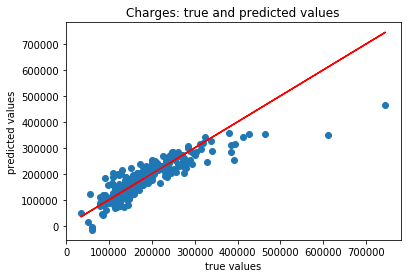

Mean absolute error of the prediction is: 26089.467873649788
Mean squared error of the prediction is: 1574193490.0112162
Root mean squared error of the prediction is: 39676.107294078334
Mean absolute percentage error of the prediction is: 16.188686003447707


In [37]:
##add constant
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

##plot predicted and true values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

